In [1]:
!pip install tensorflow

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow import keras
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cluster_war.csv')

In [ ]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df.columns

Index(['Comments', 'Cluster'], dtype='object')

In [8]:
df.head()

,Comments,Cluster
0,political battle ground subreddit please read ...,2
1,believe release hostage passed lip everyone ta...,0
2,think fact happened far away help people suppo...,1
3,mean pretty sure assumed everyone want terrori...,1
4,hamas release hostage turn war would tragedy h...,1


In [9]:
corpus=list(df['Comments'])

In [10]:
corpus[0:2]

['political battle ground subreddit please read rule commenting total karma account age threshold required post comment bot action performed automatically please contact moderator subreddit message compose question concern',
 'believe release hostage passed lip everyone talked hanging different experience']

In [11]:
max([[i,j] for i,j in zip(list(map(len,corpus)),corpus)])

[4893,
 'outright ahistorical israeli propaganda tldr time people call peace negotiation palestinian delegation israel requested ridiculous thing like access water supply complete airspace control movement control right army ground control agricultural land gaza ridiculous amount land historical significant city palestinian always wanting expand settlement cashing tva almost none time important issue like border future palestinian state status jerusalem right return palestinian refugee fate israeli settlement discussed sane delegation country would accept another country much control armistice palestinian direct representation negotiation armistice halt fighting peace settlement allon plan palestinian direct representation included significant territorial expansion west bank gaza strip made enable israeli annexation east jerusalem etzion bloc jordan valley remaining part west bank containing majority palestinian returned jordan roger plan palestinian direct representation rogers plan c

In [12]:
voc_size=23000
sent_length=700
embedding_vector_features=128

In [13]:
onehot_repr=[one_hot(words,voc_size) for words in corpus]
onehot_repr[1]

[20209, 3619, 20878, 21979, 20254, 2441, 11620, 5376, 2610, 6058]

In [14]:
corpus[1]

'believe release hostage passed lip everyone talked hanging different experience'

In [15]:
embedded_doc=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [16]:
embedded_doc[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [17]:
X=np.array(embedded_doc)
Y=np.array(df['Cluster'])

In [18]:
X.shape,Y.shape

((19908, 700), (19908,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [20]:
from keras.utils import to_categorical

# one-hot encoding of labels
y_train1 = to_categorical(y_train, num_classes=3)
y_test1 = to_categorical(y_test, num_classes=3)


1    8614
0    3403
2    1321
dtype: int64

In [21]:
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(500,return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(500))
model.add(Dropout(0.3))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 128)          2944000   
                                                                 
 dropout (Dropout)           (None, 700, 128)          0         
                                                                 
 bidirectional (Bidirection  (None, 700, 1000)         2516000   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 700, 1000)         0         
                                                                 
 lstm_1 (LSTM)               (None, 500)               3002000   
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                        

In [23]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [50]:
model_history = model.fit(X_train, y_train1, validation_data = (X_test,y_test1), epochs=100, batch_size = 64, callbacks = early_stopping)

Epoch 1/100
209/209 [==============================] - 178s 824ms/step - loss: 0.4465 - accuracy: 0.8291 - val_loss: 0.9480 - val_accuracy: 0.6230
Epoch 2/100
209/209 [==============================] - 170s 815ms/step - loss: 0.5032 - accuracy: 0.8319 - val_loss: 0.4512 - val_accuracy: 0.8426
Epoch 3/100
209/209 [==============================] - 169s 811ms/step - loss: 0.2513 - accuracy: 0.9156 - val_loss: 0.3232 - val_accuracy: 0.8980
Epoch 4/100
209/209 [==============================] - 168s 806ms/step - loss: 0.1327 - accuracy: 0.9558 - val_loss: 0.2430 - val_accuracy: 0.9132
Epoch 5/100
209/209 [==============================] - 169s 807ms/step - loss: 0.0595 - accuracy: 0.9783 - val_loss: 0.3219 - val_accuracy: 0.9137
Epoch 6/100
209/209 [==============================] - 168s 806ms/step - loss: 0.0411 - accuracy: 0.9855 - val_loss: 0.3103 - val_accuracy: 0.9134
Epoch 7/100
209/209 [==============================] - 168s 806ms/step - loss: 0.0313 - accuracy: 0.9889 - val_loss: 0

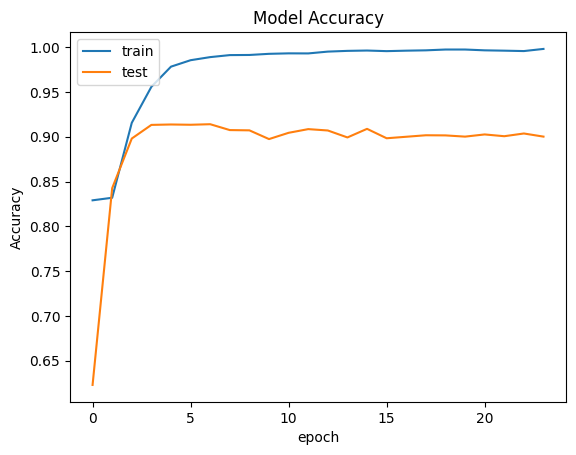

In [51]:
plt.plot(model_history.history[ 'accuracy'])
plt.plot(model_history.history[ 'val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

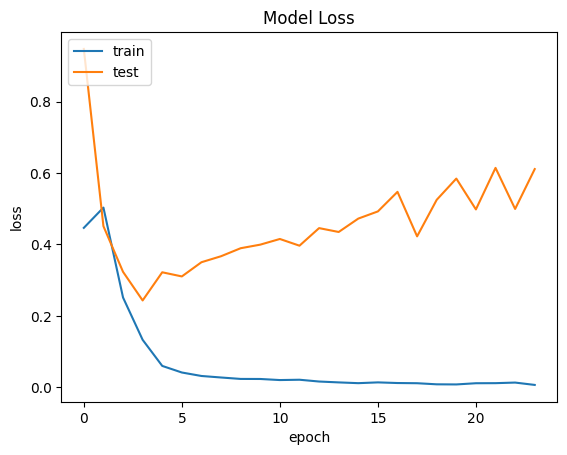

In [52]:
plt.plot(model_history.history[ 'loss'])
plt.plot(model_history.history[ 'val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
y_pred=model.predict(X_test)

206/206 [==============================] - 27s 128ms/step


In [54]:
y_pred=np.argmax(y_pred, axis=-1)

In [61]:
y_pred[0:100]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 2])

In [ ]:
# class_labels = ["Cluster 0", "Cluster 1", "Cluster 2"]  # Replace with actual class labels
# predicted_class_label = class_labels[y_pred[0]]

# print(f"Predicted class: {predicted_class_label}")

In [62]:
confusion_matrix(y_test,y_pred)

array([[1468,  203,    8],
       [ 260, 3940,   38],
       [  57,   90,  506]])

In [63]:
accuracy_score(y_test,y_pred)

0.9001522070015221

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1679
           1       0.93      0.93      0.93      4238
           2       0.92      0.77      0.84       653

    accuracy                           0.90      6570
   macro avg       0.89      0.86      0.87      6570
weighted avg       0.90      0.90      0.90      6570



In [24]:
def model_builder(hp):
  model =Sequential()
  hp_units1 = hp.Int('dim', min_value=32, max_value=512, step=32)
  model.add(Embedding(voc_size, hp_units1, input_length=sent_length))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 500-2000
  hp_units2 = hp.Int('units1', min_value=300, max_value=700, step=100)
  model.add(Bidirectional(LSTM(hp_units2,return_sequences=True)))

  hp_unit3 = hp.Int('units2', min_value=300, max_value=700, step=100)
  model.add(LSTM(hp_units2))
  model.add(Dense(units=3, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [25]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='Tuner1',
                     project_name='Cluster_war')

In [67]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train1, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 21 Complete [00h 12m 28s]
val_accuracy: 0.914917528629303

Best val_accuracy So Far: 0.9212893843650818
Total elapsed time: 02h 49m 55s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
384               |416               |dim
300               |300               |units1
600               |700               |units2
0.0001            |0.0001            |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
 18/334 [>.............................] - ETA: 2:19:15 - loss: 1.0245 - accuracy: 0.6319

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the Bidirectional LSTM
layer is {best_hps.get('units1')} and The optimal number of units in the LSTM
layer is {best_hps.get('units2')} andthe optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the optimal number of dimesnion is{best_hps.get('dim')}.
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)